In [1]:
import tensorflow
from tensorflow.keras.datasets import mnist
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score as accuracy
import matplotlib.pyplot as plt
from sklearn.cluster import MiniBatchKMeans
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA 

In [2]:
class main():
    def __init__(self):
        '''
        This will initiate the K-Means and Gaussian Models and train them on the training data, raw. 
        Also preprocesses the data and makes the data ready to be played with. 
        '''
        (x_train, y_train), (x_test, y_test) = mnist.load_data()
        self.x_train = x_train.reshape(len(x_train), -1)/255
        self.y_train = y_train
        self.x_test = x_test.reshape(len(x_test), -1)/255
        self.y_test = y_test
        self.gmm_predictions = None
        self.gmm_labels = None
        self.kmeans_labels = None
        self.kmeans_predictions = None
        self.gmm_model = None
        self.kmeans_model = None
    def pca(self, transform):
        '''
        This helps us to do PCA to degree 2. 
        '''
        model= PCA(2)
        model.fit(self.x_train)
        return model.transform(transform)
    def gmm(self, cov):
        '''
        This is to train the GMM model in the beginning. 
        '''
        model = GaussianMixture(n_components=10, covariance_type=cov, verbose=2)
        model.fit(self.x_train)
        self.gmm_model = model
        self.gmm_labels = model.predict(self.x_test)
    def infer_labels(self,actual_labels, x_labels):
        '''
        This helps us to infer labels as in for what they mean.
        '''
        if(x_labels.shape != actual_labels.shape):
            print("Error: Shape of x_labels is not same as that of actual_labels")
            return
        new_labels = {}
        for i in range(10):
            labels = []
            index = np.where(x_labels == i)
            labels.append(actual_labels[index])
            if len(labels[0]) == 1:
                counts = np.bincount(labels[0])
            else:
                counts = np.bincount(np.squeeze(labels))
            if(len(counts) == 0):
                continue
            if np.argmax(counts) in new_labels:
                new_labels[np.argmax(counts)].append(i)
            else:
                new_labels[np.argmax(counts)] = [i] 
        return new_labels
    def get_labels(self, cluster_labels, x_labels):
        '''
        This helps us to get the actual predictions. 
        '''
        # empty array of len(X)
        predicted_labels = np.zeros(len(x_labels)).astype(np.uint8)
        for i, cluster in enumerate(x_labels):
            for key, value in cluster_labels.items():
                if cluster in value:
                    predicted_labels[i] = key
                
        return predicted_labels
    def kmeans(self):
        model = MiniBatchKMeans(n_clusters=10)
        model.fit(self.x_train)
        self.kmeans_labels = model.predict(self.x_test)
        self.kmeans_model = model
    def accuracy(self, n1, n2):
        print(str(accuracy(n1, n2)*100)+"%")
        return accuracy(n1, n2)*100
    def kmeans_predict(self, data,test_data,  actual_data, n_clusters):
        model = MiniBatchKMeans(n_clusters=n_clusters)
        model.fit(data)
        data = model.predict(test_data)
        return self.get_labels(cluster_labels=self.infer_labels(actual_labels=actual_data, x_labels=data), x_labels=data)
    def gmm_predict(self, data,test_data,  actual_data, cov):
        model = GaussianMixture(n_components=10, covariance_type=cov)
        model.fit(data)
        data = model.predict(test_data)
        return self.get_labels(cluster_labels=self.infer_labels(actual_labels=actual_data, x_labels=data), x_labels=data)
    def plot(self, data, x_test_labels):
        if(data.shape[1] != 2):
            print("Error: Cannot plot > 2 dimensional data")
        for i in np.unique(x_test_labels):
            plt.scatter(data[x_test_labels == i, 0], data[x_test_labels==i, 1], label=i)
        plt.legend()
        plt.show()
    def pca_degree(self, degree, data):
        model = PCA(degree)
        model.fit(self.x_train)
        return model.transform(self.x_train), model.transform(data)
    def kmeans_obj_function(self, model, train_data):
        # 
        cluster_centers = model.cluster_centers_
        

In [3]:
main_object = main()

Initialization 0
  Iteration 10	 time lapse 7.92760s	 ll change 2.69244
  Iteration 20	 time lapse 5.08933s	 ll change 0.86424
  Iteration 30	 time lapse 5.04345s	 ll change 0.07432
  Iteration 40	 time lapse 5.03341s	 ll change 0.02724
Initialization converged: True	 time lapse 25.11683s	 ll 2234.68344


In [4]:
cluster_labels = main_object.infer_labels(actual_labels=main_object.y_test, x_labels=main_object.kmeans_labels)

In [5]:
main_object.kmeans_predictions = main_object.get_labels(cluster_labels=cluster_labels, x_labels=main_object.kmeans_labels)

In [6]:
print(main_object.accuracy(main_object.kmeans_predictions, main_object.y_test))

61.68%
61.68


In [7]:
cluster_labels = main_object.infer_labels(actual_labels=main_object.y_test, x_labels=main_object.gmm_labels)

In [8]:
main_object.gmm_predictions = main_object.get_labels(cluster_labels=cluster_labels, x_labels=main_object.gmm_labels)

In [9]:
print("K-Means Plain:")
print(main_object.accuracy(main_object.kmeans_predictions, main_object.y_test))
print("GMM Plain:")
print(main_object.accuracy(main_object.gmm_predictions, main_object.y_test))

K-Means Plain:
61.68%
61.68
GMM Plain:
41.0%
41.0


In [10]:
pca_x_train = main_object.pca(main_object.x_train)
pca_x_test = main_object.pca(main_object.x_test)
pca_kmeans_predictions = main_object.kmeans_predict(actual_data=main_object.y_test, test_data=pca_x_test, data=pca_x_train, n_clusters=11)

In [11]:
print("PCA -> K-Means:")
main_object.accuracy(pca_kmeans_predictions, main_object.y_test)

PCA -> K-Means:
41.82%


41.82

In [12]:
pca_gmm_predictions = main_object.gmm_predict(test_data=pca_x_test, data=pca_x_train, actual_data=main_object.y_test, cov='diag')
print("PCA -> GMM: ")
print(main_object.accuracy(pca_gmm_predictions, main_object.y_test))

PCA -> GMM: 
40.56%
40.56


PCA -> K-Means Plot:


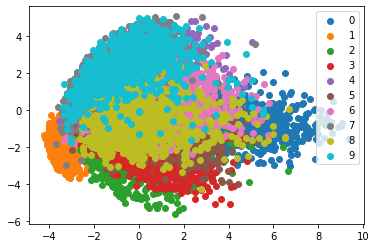

None


In [13]:
print("PCA -> K-Means Plot:")
print(main_object.plot(data=pca_x_test, x_test_labels=main_object.y_test))


PCA -> GMM Plot:


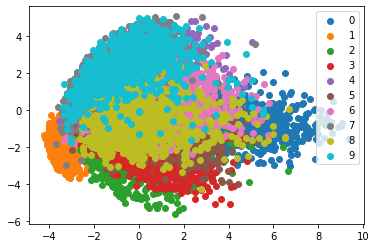

In [14]:
print("PCA -> GMM Plot:")
main_object.plot(pca_x_test, x_test_labels =main_object.y_test)

GMM Plot:


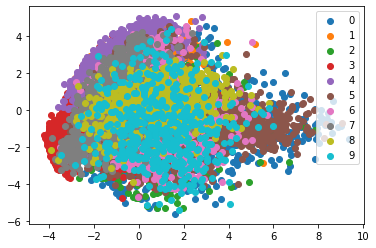

In [15]:
print("GMM Plot:")
main_object.plot(pca_x_test, main_object.gmm_labels)

K-Means Plot:


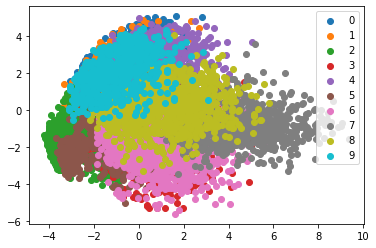

In [16]:
print("K-Means Plot:")
main_object.plot(pca_x_test, main_object.kmeans_labels)

In [17]:
pca_110_train, pca_110_test = main_object.pca_degree(21, main_object.x_test)


In [18]:
pca_110_predictions = main_object.gmm_predict(test_data=pca_110_test, actual_data=main_object.y_test, cov = 'diag', data = pca_110_train)

In [19]:
print("PCA(21) -> GMM:")
print(main_object.accuracy(pca_110_predictions, main_object.y_test))

PCA(21) -> GMM:
54.72%
54.72


In [20]:
print("PCA(12) -> Kmeans:")
pca_x_train, pca_x_test = main_object.pca_degree(12, main_object.x_test)
pca_kmeans_predictions = main_object.kmeans_predict(test_data=pca_x_test, actual_data=main_object.y_test, data=pca_x_train, n_clusters=10)
print(main_object.accuracy(pca_kmeans_predictions, main_object.y_test))

PCA(12) -> Kmeans:
57.42%
57.42


In [21]:
print("PCA(12) -> Kmeans (11):")
pca_x_train, pca_x_test = main_object.pca_degree(10, main_object.x_test)
pca_kmeans_predictions = main_object.kmeans_predict(test_data=pca_x_test, actual_data=main_object.y_test, data=pca_x_train, n_clusters=11)
print(main_object.accuracy(pca_kmeans_predictions, main_object.y_test))

PCA(12) -> Kmeans (11):
55.900000000000006%
55.900000000000006


In [54]:
kmeans_pca_dict = {}
for i in range(100):
    pca_x_train, pca_x_test = main_object.pca_degree(10, main_object.x_test)
    pca_kmeans_predictions = main_object.kmeans_predict(test_data=pca_x_test, actual_data=main_object.y_test, data=pca_x_train, n_clusters=11)
    print(i, end = ': ')
    kmeans_pca_dict[i] = main_object.accuracy(pca_kmeans_predictions, main_object.y_test)

0: 57.379999999999995%
1: 48.99%
2: 54.949999999999996%
3: 53.65%
4: 55.48%
5: 53.879999999999995%
6: 57.37%
7: 58.15%
8: 51.65%
9: 53.779999999999994%
10: 49.79%
11: 56.169999999999995%
12: 54.6%
13: 58.47%
14: 53.22%
15: 50.849999999999994%
16: 52.769999999999996%
17: 54.25%
18: 53.010000000000005%
19: 58.199999999999996%
20: 48.96%
21: 54.97%
22: 57.489999999999995%
23: 50.44%
24: 52.059999999999995%
25: 57.379999999999995%
26: 48.83%
27: 54.59%
28: 48.699999999999996%
29: 50.05%
30: 54.86%
31: 47.38%
32: 59.79%
33: 53.849999999999994%
34: 52.59%
35: 49.15%
36: 49.43%
37: 51.04%
38: 54.54%
39: 54.410000000000004%
40: 53.32%
41: 50.81%
42: 52.62%
43: 53.44%
44: 60.519999999999996%
45: 51.949999999999996%
46: 53.44%
47: 53.93%
48: 51.05%
49: 56.089999999999996%
50: 53.87%
51: 53.080000000000005%
52: 58.98%
53: 56.26%
54: 54.49%
55: 51.449999999999996%
56: 59.17%
57: 61.62%
58: 52.93%
59: 59.63%
60: 52.42%
61: 55.06999999999999%
62: 50.339999999999996%
63: 48.08%
64: 50.980000000000004

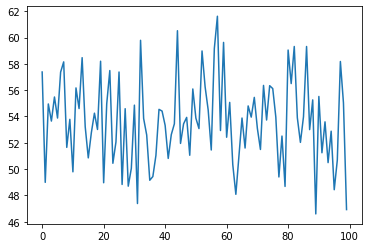

In [55]:

plt.plot(kmeans_pca_dict.keys(), kmeans_pca_dict.values())
plt.savefig('./submission/k_means_iterative_trails/3.png')
plt.show()


In [56]:
for key, value in kmeans_pca_dict.items():
    if value == 60.5:
        print(key)
        break

In [57]:
file = open('./submission/k_means_iterative_trails/3.txt', 'w')
file.write(str(sorted(kmeans_pca_dict.items(), key = lambda kv:(kv[1], kv[0]))))

1737

In [58]:
str(sorted(kmeans_pca_dict.items(), key = lambda kv:(kv[1], kv[0])))

'[(89, 46.589999999999996), (99, 46.92), (31, 47.38), (63, 48.08), (95, 48.43), (79, 48.68), (28, 48.699999999999996), (26, 48.83), (20, 48.96), (1, 48.99), (35, 49.15), (77, 49.4), (36, 49.43), (10, 49.79), (29, 50.05), (62, 50.339999999999996), (23, 50.44), (93, 50.49), (96, 50.68), (41, 50.81), (15, 50.849999999999994), (64, 50.980000000000004), (37, 51.04), (48, 51.05), (91, 51.239999999999995), (55, 51.449999999999996), (71, 51.49), (66, 51.6), (8, 51.65), (45, 51.949999999999996), (84, 52.03), (24, 52.059999999999995), (60, 52.42), (78, 52.51), (34, 52.59), (42, 52.62), (16, 52.769999999999996), (94, 52.88), (58, 52.93), (87, 53.0), (18, 53.010000000000005), (51, 53.080000000000005), (70, 53.09), (14, 53.22), (40, 53.32), (43, 53.44), (46, 53.44), (92, 53.59), (3, 53.65), (73, 53.73), (9, 53.779999999999994), (33, 53.849999999999994), (50, 53.87), (5, 53.879999999999995), (65, 53.879999999999995), (83, 53.900000000000006), (47, 53.93), (68, 53.949999999999996), (76, 53.9499999999